# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',  sep=';')

#load in customer_subset 
Customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [3]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
Customer.head(n=15)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.tail(n=100)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
missingazdias = azdias.isnull().sum()
missingazdias

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
missingazdias = azdias.isnull().sum().sum()
print ('the sum of missing values before processing  {}:'.format(missingazdias))

the sum of missing values before processing  4896838:


In [10]:
azdias.shape[1]

85

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
for column in range(feat_info.shape[1]):
    missing_or_unknown = feat_info.iloc[column]['missing_or_unknown'].strip('[]').split(',')
    missing_or_unknown = [float(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[column]['attribute']: missing_or_unknown}, np.nan)
        azdias=azdias.replace({column:['XX','X']},np.nan)

In [12]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          8863

In [13]:
print ('the total values of missing after processing {}'.format(azdias.isnull().sum().sum()))

the total values of missing after processing 5585562


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missed = azdias.isnull().sum()
missed

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

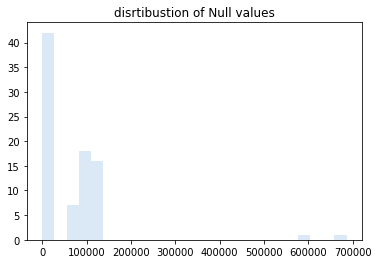

In [15]:
sns.set_palette('Blues')
plt.hist(missed, bins=25 )
plt.title('disrtibustion of Null values')
plt.show()

(array([ 42.,  41.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([      0. ,   68584.3,  137168.6,  205752.9,  274337.2,  342921.5,
         411505.8,  480090.1,  548674.4,  617258.7,  685843. ]),
 <a list of 10 Patch objects>)

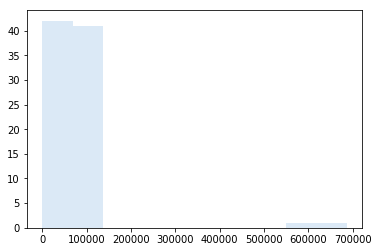

In [16]:
# Investigate patterns in the amount of missing data in each column.
#anathor method for represniting histogram 
plt.hist(missed)

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#dropped whatis value more than  200 K, so we can count values more than 30 and values less than 30 
missed_less_200k = missed[missed <= 200000 ]
missed_more_200k  =  missed[missed >= 200000 ]
print ('number of than 200k is {}'.format(missed_more_200k.shape[0]))

number of than 200k is 2


In [18]:
#remove data with more than 200000 missing values 
azdias.drop(missed_more_200k.index, axis=1, inplace=True)
azdias.shape

(891221, 83)

In [19]:
missed_less_200k

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
                          ...  
OST_WEST

In [20]:
missed_more_200k

AGER_TYP        685843
KK_KUNDENTYP    584612
dtype: int64

#### Discussion 1.1.2: Assess Missing Data in Each Column
##### 1- missing_or _unknow in feat_info data set is object 
        but all data in azdias data set is a float or int  so we need to assessing missing data in feat info so we can make    this comaprison 

##### 2- some customization done at feat info 
        a- removiong []
        b- splitting data by comma to convert it to list 
        c- change values from str to int 
        d- some values like X and XXnot changed and we will deal with it later 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
missed_1 = azdias.isnull().sum(axis =1)
missed_1

0         41
1          0
2          0
3          1
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        41
12         7
13         9
14        41
15         8
16         1
17        41
18         0
19         0
20        10
21         0
22         0
23         8
24        41
25         1
26        20
27         0
28         0
29         0
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    10
891204     0
891205     0
891206     0
891207     0
891208     0
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     0
891218     1
891219     0
891220     0
Length: 891221, dtype: int64

(array([  7.43818000e+05,   2.19530000e+04,   1.81470000e+04,
          1.20040000e+04,   2.03900000e+03,   7.80000000e+01,
          3.40000000e+01,   1.95490000e+04,   0.00000000e+00,
          7.35990000e+04]),
 array([  0. ,   4.5,   9. ,  13.5,  18. ,  22.5,  27. ,  31.5,  36. ,
         40.5,  45. ]),
 <a list of 10 Patch objects>)

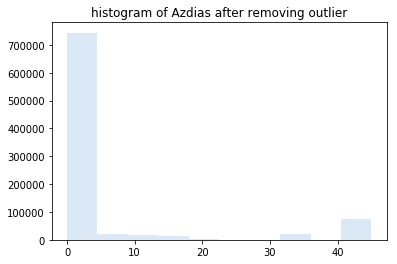

In [22]:
plt.title('histogram of Azdias after removing outlier')
plt.hist(missed_1)

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missed_less_20 = azdias [missed_1 < 20 ]
missed_more_20  =  azdias [missed_1 >= 20 ]
print ('number of than 20 is {}'.format(missed_more_20.shape[0]))

number of than 20 is 94493


In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
column_with_no_missed_data = missed_1[missed_1==0] 
column_with_no_missed_data = column_with_no_missed_data.index
column_with_no_missed_data

Int64Index([     1,      2,      4,      5,      6,      7,      8,      9,
                10,     18,
            ...
            891209, 891210, 891211, 891212, 891213, 891214, 891215, 891217,
            891219, 891220],
           dtype='int64', length=695414)

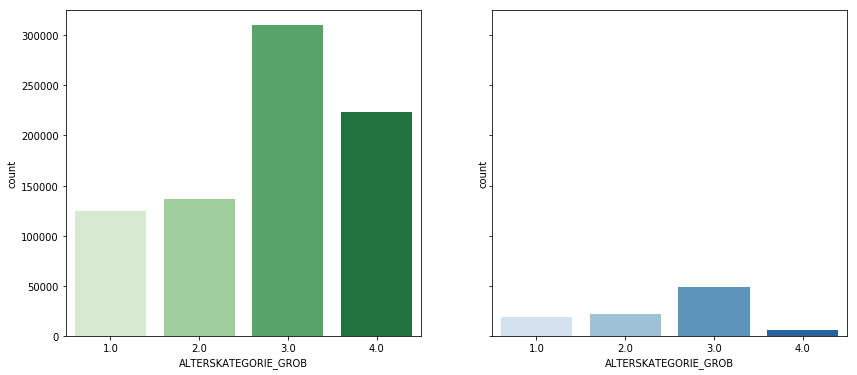

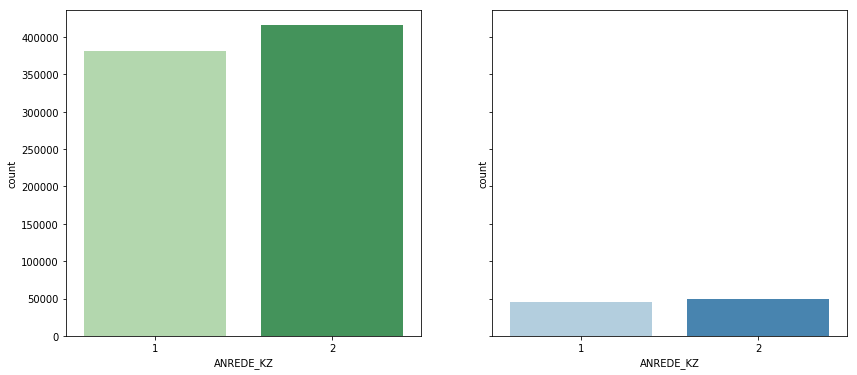

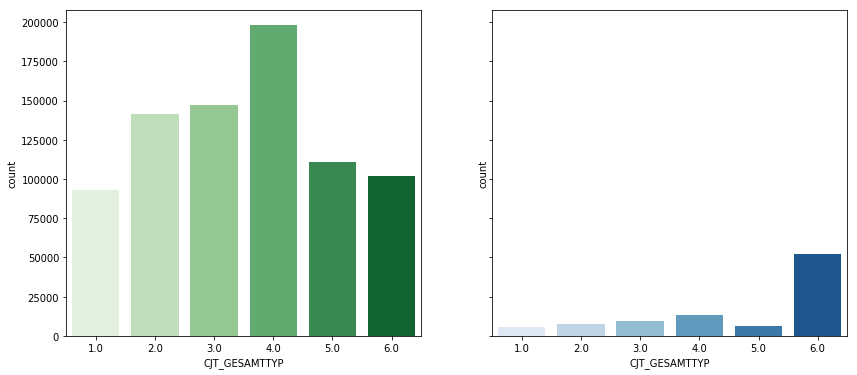

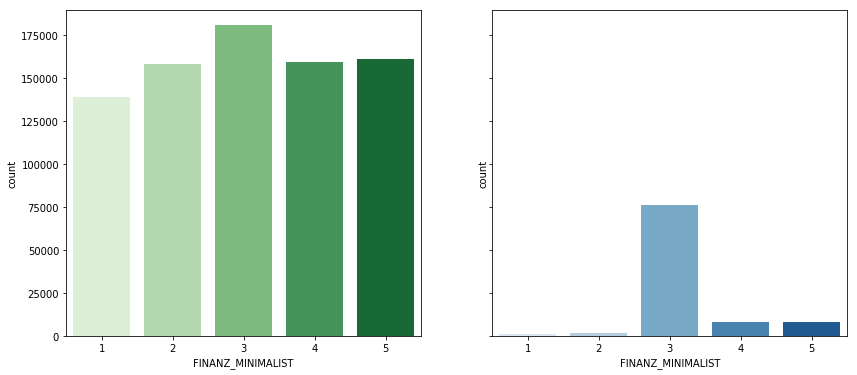

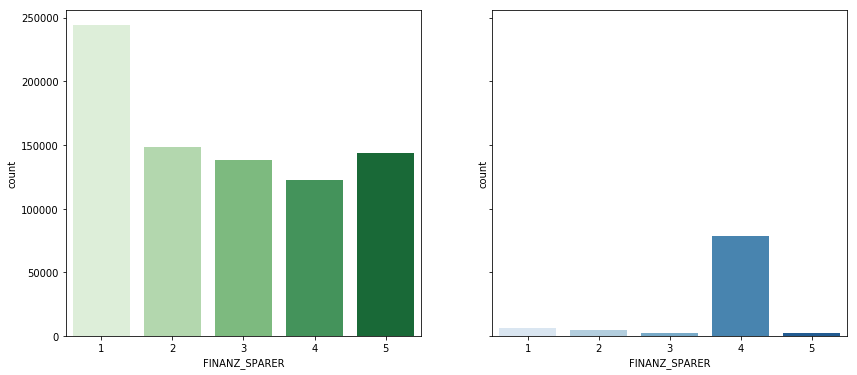

In [25]:
for col in azdias.columns[0:5]:
    fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
    sns.countplot(missed_less_20.loc[:,col], ax=axes[0],  palette="Greens")
    sns.countplot(missed_more_20.loc[:,col], ax=axes[1], palette="Blues")

In [26]:
#anathor method fot plotting 

#fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,30))
#n=0
#sns.set_palette("hls", 8)
#for column in azdias.columns[0:5]:
    #sns.countplot(missed_less_20.loc[:, column], ax=axes[n,0])
   # axes[n,0].set_title('Low Missing Per Row')
    #sns.countplot(missed_more_20.loc[:, column], ax=axes[n,1])
    #axes[n,1].set_title('High Missing Per Row')
   # n+=1

#### Discussion 1.1.3: Assess Missing Data in Each Row

###### we have divided data to missed_more_200k and missed_less_200k and removed data with values more than 20000 and making assessing again to data and remove missed_more_20 , now our data is without outlier 
##### applied impution with SK leatn and then 
##### coudln't impute direct should to change tonumeriic and float 
####  plotting  countplot for 5 column of azdias dats set show high count for missed _less_20

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
feat_type =  feat_info.type.value_counts()
feat_type

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [28]:
new_feat_info = feat_info[feat_info['type'] == 'categorical']
new_feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [29]:
categorical_attrib =  feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical_attrib  = [x for x in categorical_attrib  if x in missed_less_20.columns] 
categorical_attrib

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
multi_feature=[]
single_feature = []
binary_feature =[]
for x in categorical_attrib :
    if (len(missed_less_20[x].unique())>2):
        multi_feature.append(x)
    elif (len(missed_less_20[x].unique())==2):
        binary_feature.append(x)
print ('mulit feature {}'.format(multi_feature))

mulit feature ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
print ('binary_feature{}'.format(binary_feature))  

binary_feature['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [32]:
print ('categorical is {}'.format(categorical_attrib))

categorical is ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [33]:
azdias[multi_feature].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     12
LP_FAMILIE_GROB      6
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     4
SHOPPER_TYP          5
TITEL_KZ             6
VERS_TYP             3
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015     10
CAMEO_DEU_2015      45
dtype: int64

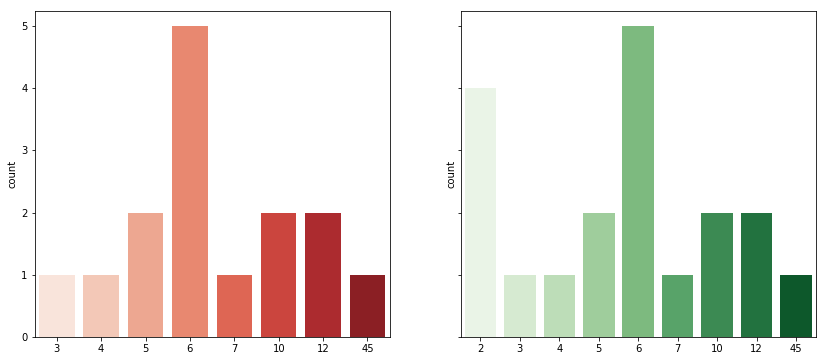

In [34]:
fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
sns.countplot(azdias[multi_feature].nunique(), ax=axes[0],  palette="Reds")
sns.countplot(azdias[categorical_attrib].nunique(), ax=axes[1], palette="Greens")

In [35]:
azdias[multi_feature].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     12
LP_FAMILIE_GROB      6
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     4
SHOPPER_TYP          5
TITEL_KZ             6
VERS_TYP             3
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015     10
CAMEO_DEU_2015      45
dtype: int64

In [36]:
len(multi_feature) , len(binary_feature)

(15, 4)

In [37]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, missed_less_20[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
encoded_azdias = missed_less_20.replace({'OST_WEST_KZ':{'W':0,'O':1}})

In [39]:
for feature in binary_feature:
    print('values {} with unique are {}'.format(feature, encoded_azdias[feature].unique()))

values ANREDE_KZ with unique are [2 1]
values GREEN_AVANTGARDE with unique are [0 1]
values SOHO_KZ with unique are [ 1.  0.]
values OST_WEST_KZ with unique are [0 1]


In [40]:
for feature in multi_feature:
    encoded_azdias.drop(feature , axis=1 )

#### Discussion 1.2.1: Re-Encode Categorical Features
we have divied categorical attribute to 
    MULTIFEATURE 
    BINARY _FEATURE 
##### for multi_feature we removed (CAMEO_DEU_2015) as its corrosponding values 45 
##### for (OST_WEST_KZ) we replace w  with 0 and O with 1 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
encoded_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [42]:
mixed_feat_info = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed_feat_info = [x for x in mixed_feat_info if x in missed_less_20.columns] 
azdias[mixed_feat_info].nunique()

LP_LEBENSPHASE_FEIN      41
LP_LEBENSPHASE_GROB      13
PRAEGENDE_JUGENDJAHRE    16
WOHNLAGE                  8
CAMEO_INTL_2015          22
KBA05_BAUMAX              6
PLZ8_BAUMAX               5
dtype: int64

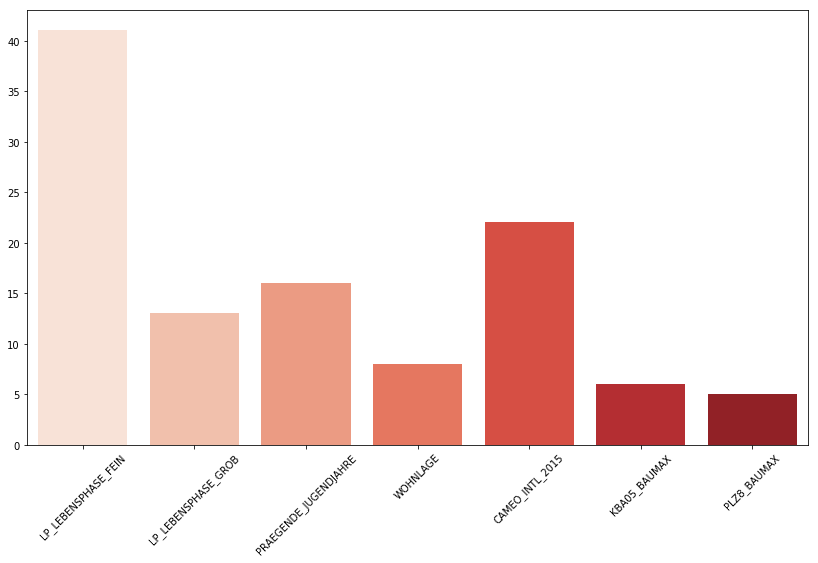

In [43]:
fig, ax1 = plt.subplots(figsize=(14,8))
sns.barplot( azdias[mixed_feat_info].nunique().index   , azdias[mixed_feat_info].nunique() , palette="Reds")
plt.xticks(rotation = 45)
plt.show()

In [44]:
new_feat_info = feat_info[feat_info['type'] == 'mixed']
new_feat_info

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [45]:
encoded_azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14    182598
8     141390
10     85682
5      84617
3      53784
15     42409
11     35671
9      33556
0      28607
6      25650
12     24432
1      20648
4      20446
2       7478
13      5751
7       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

### below code is from udacity knowledge 

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
encoded_azdias['DECADE'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
encoded_azdias['MOVEMENT'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']

In [47]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [48]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3,
               '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3,
                   '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
encoded_azdias['WEALTH'] = encoded_azdias['CAMEO_INTL_2015']
encoded_azdias['LIFE_STAGE'] = encoded_azdias['CAMEO_INTL_2015']

In [50]:
encoded_azdias['WEALTH'].replace(wealth_dict, inplace=True) 
encoded_azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)


In [51]:
encoded_azdias=encoded_azdias.replace({col:['XX','X']},np.nan)

In [52]:
encoded_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796728 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     793930 non-null float64
ANREDE_KZ                796728 non-null int64
CJT_GESAMTTYP            792087 non-null float64
FINANZ_MINIMALIST        796728 non-null int64
FINANZ_SPARER            796728 non-null int64
FINANZ_VORSORGER         796728 non-null int64
FINANZ_ANLEGER           796728 non-null int64
FINANZ_UNAUFFAELLIGER    796728 non-null int64
FINANZ_HAUSBAUER         796728 non-null int64
FINANZTYP                796728 non-null int64
GEBURTSJAHR              796728 non-null int64
GFK_URLAUBERTYP          792087 non-null float64
GREEN_AVANTGARDE         796728 non-null int64
HEALTH_TYP               796728 non-null int64
LP_LEBENSPHASE_FEIN      792087 non-null float64
LP_LEBENSPHASE_GROB      792087 non-null float64
LP_FAMILIE_FEIN          792087 non-null float64
LP_FAMILIE_GROB          792087 non-null float64
LP_STATUS_FEIN           7920

#### Discussion 1.2.2: Engineer Mixed-Type Features

###### encoded mixed feature CAMEO_INTL_2015 with deace and wealth and LIFE_STAGE to capture the two dimension of this variable  and then replace with dictionary of wealth and life stage  dictionary 
###### encoded  PRAEGENDE_JUGENDJAHRE  as its contain information of multidimesnion  so it will converted to decade and movemnet 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
encoded_azdias = encoded_azdias.convert_objects(convert_numeric=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
encoded_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796728 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     793930 non-null float64
ANREDE_KZ                796728 non-null int64
CJT_GESAMTTYP            792087 non-null float64
FINANZ_MINIMALIST        796728 non-null int64
FINANZ_SPARER            796728 non-null int64
FINANZ_VORSORGER         796728 non-null int64
FINANZ_ANLEGER           796728 non-null int64
FINANZ_UNAUFFAELLIGER    796728 non-null int64
FINANZ_HAUSBAUER         796728 non-null int64
FINANZTYP                796728 non-null int64
GEBURTSJAHR              796728 non-null int64
GFK_URLAUBERTYP          792087 non-null float64
GREEN_AVANTGARDE         796728 non-null int64
HEALTH_TYP               796728 non-null int64
LP_LEBENSPHASE_FEIN      792087 non-null float64
LP_LEBENSPHASE_GROB      792087 non-null float64
LP_FAMILIE_FEIN          792087 non-null float64
LP_FAMILIE_GROB          792087 non-null float64
LP_STATUS_FEIN           7920

In [55]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

encoded_azdias.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,1.0,2.0,3.0,NaN,NaN,NaN,14,14,4.0,1.0
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,4.0,5.0,3.0,4.0,6.0,5.0,10,10,5.0,1.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,1.0,3.0,4.0,2.0,2.0,3.0,14,14,2.0,4.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,5.0,1.0,1.0,4.0,7.0,5.0,14,14,5.0,1.0
891220,4.0,1,1.0,4,2,5,2,1,5,6,...,1.0,4.0,4.0,3.0,4.0,5.0,3,3,4.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the general demographics data.
    azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',  sep=';')
    
    
    # Identify missing or unknown data values and convert them to NaNs.

    # Identify missing or unknown data values and convert them to NaNs.
    for column in range(feat_info.shape[1]):
        missing_or_unknown = feat_info.iloc[column]['missing_or_unknown'].strip('[]').split(',')
        missing_or_unknown = [float(value) if (float(value)!='X' and float(value)!='XX' and float(value)!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            azdias = azdias.replace({feat_info.iloc[column]['attribute']: missing_or_unknown}, np.nan)

    missed = azdias.isnull().sum()
    missed
    #dropped whatis value more than  200 K, so we can count values more than 30 and values less than 30 
    missed_less_200k = missed[missed <= 200000 ]
    missed_more_200k  =  missed[missed >= 200000 ]
    #print ('number of than 200k is {}'.format(missed_more_200K.shape[0]))
    
    #remove data with more than 200000 missing values 
    azdias.drop(missed_more_200k.index, axis=1, inplace=True)
    # Put in code here to execute all main cleaning steps:
    
    # How much data is missing in each row of the dataset?
    missed_1 = azdias.isnull().sum(axis =1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.

    missed_less_20 = azdias [missed_1 < 20 ]
    missed_more_20  =  azdias [missed_1 >= 20 ]
    print ('number of than 20 is {}'.format(missed_more_20.shape[0]))
        
        
     #How many features are there of each data type?
    feat_type =  feat_info.type.value_counts()
    new_feat_info = feat_info[feat_info['type'] == 'categorical']
    
    categorical_attrib =  feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_attrib  = [x for x in categorical_attrib  if x in missed_less_20.columns] 
    
    # Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
    multi_feature=[]
    single_feature = []
    binary_feature =[]
    for x in categorical_attrib :
        if (len(missed_less_20[x].unique())>2):
            multi_feature.append(x)
        elif (len(missed_less_20[x].unique())==2):
            binary_feature.append(x)
    print ('mulit feature {}'.format(multi_feature))
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    encoded_azdias = missed_less_20.replace({'OST_WEST_KZ':{'W':0,'O':1}})
    
    #dropping mulitfeature 
    for feature in multi_feature:
        encoded_azdias.drop(feature , axis=1 )
    
    mixed_feat_info = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed_feat_info = [x for x in mixed_feat_info if x in missed_less_20.columns] 
    azdias[mixed_feat_info].nunique()
    
    
    new_feat_info = feat_info[feat_info['type'] == 'mixed']
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    encoded_azdias['DECADE'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
    encoded_azdias['MOVEMENT'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3,
               '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3,
                   '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    encoded_azdias['WEALTH'] = encoded_azdias['CAMEO_INTL_2015'] 
    encoded_azdias['LIFE_STAGE'] = encoded_azdias['CAMEO_INTL_2015']
    
    encoded_azdias['WEALTH'].replace(wealth_dict, inplace=True) 
    encoded_azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

    # convert missing value codes into NaNs, ...
    
    encoded_azdias = encoded_azdias.convert_objects(convert_numeric=True)
    # remove selected columns and rows, ...

    display(encoded_azdias)
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    return encoded_azdias

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df = clean_data(azdias)

number of than 20 is 94493
mulit feature ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:102: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,...,1.0,5.0,4.0,3.0,5.0,4.0,14,14,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,4.0,4.0,3.0,5.0,2.0,15,15,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,1.0,3.0,4.0,2.0,3.0,3.0,8,8,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,3.0,3.0,4.0,6.0,5.0,8,8,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,5.0,5.0,2.0,3.0,3.0,3,3,5.0,4.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,1.0,5.0,5.0,4.0,6.0,3.0,10,10,2.0,2.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,1.0,4.0,4.0,2.0,5.0,2.0,8,8,1.0,4.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,1.0,3.0,3.0,2.0,4.0,3.0,11,11,1.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,1.0,3.0,3.0,2.0,3.0,1.0,15,15,1.0,5.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,3.0,3.0,4.0,6.0,5.0,3,3,5.0,1.0


#### check  precentage of null in every column 

In [58]:
(df.isnull().sum()/df.sum()).sort_values(ascending= False)

KBA05_ANTG4             0.167488
ANZ_HH_TITEL            0.118021
KBA05_ANTG3             0.082045
PLZ8_ANTG4              0.040661
KBA05_ANTG2             0.040487
KBA05_BAUMAX            0.036875
KBA05_ANTG1             0.034290
PLZ8_ANTG3              0.017819
MOBI_REGIO              0.017290
KBA05_GBZ               0.016222
PLZ8_BAUMAX             0.014625
KKK                     0.013404
PLZ8_ANTG1              0.012616
W_KEIT_KIND_HH          0.010814
PLZ8_ANTG2              0.010146
PLZ8_GBZ                0.008408
REGIOTYP                0.008163
PLZ8_HHZ                0.007869
LP_FAMILIE_GROB         0.002550
LP_STATUS_GROB          0.002383
LIFE_STAGE              0.002183
ONLINE_AFFINITAET       0.002145
WEALTH                  0.001923
RETOURTYP_BK_S          0.001702
CJT_GESAMTTYP           0.001673
RELAT_AB                0.001665
ARBEIT                  0.001615
LP_FAMILIE_FEIN         0.001550
ALTERSKATEGORIE_GROB    0.001261
LP_LEBENSPHASE_GROB     0.001252
          

In [59]:
df_1= df.dropna()

In [60]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695169 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     695169 non-null float64
ANREDE_KZ                695169 non-null int64
CJT_GESAMTTYP            695169 non-null float64
FINANZ_MINIMALIST        695169 non-null int64
FINANZ_SPARER            695169 non-null int64
FINANZ_VORSORGER         695169 non-null int64
FINANZ_ANLEGER           695169 non-null int64
FINANZ_UNAUFFAELLIGER    695169 non-null int64
FINANZ_HAUSBAUER         695169 non-null int64
FINANZTYP                695169 non-null int64
GEBURTSJAHR              695169 non-null int64
GFK_URLAUBERTYP          695169 non-null float64
GREEN_AVANTGARDE         695169 non-null int64
HEALTH_TYP               695169 non-null int64
LP_LEBENSPHASE_FEIN      695169 non-null float64
LP_LEBENSPHASE_GROB      695169 non-null float64
LP_FAMILIE_FEIN          695169 non-null float64
LP_FAMILIE_GROB          695169 non-null float64
LP_STATUS_FEIN           6951

In [61]:
#the percentage of null rows  in data 
(df.shape[0] - df_1.shape[0])/df.shape[0]

0.12747010272012532

In [62]:
#df_1 = pd.get_dummies (df_1, columns = lst)
#print (df_1.shape)
#display (list (df_1.columns))

In [63]:
df_1.isnull().sum().sum()

0

In [64]:
#xx = ['XX', 'X' ,'6B','9D','5A','3A']
#df_1.replace (to_replace = xx, value = np.NaN, regex = True, inplace = True)

In [65]:
df_1 = df_1.convert_objects(convert_numeric=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [66]:
l = df_1['CAMEO_DEU_2015'].unique()
l

array(['8A', '4C', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5D', '9E',
       '9B', '2A', '1B', '8B', '3D', '7A', '4E', '4B', '3C', '5A', '7B',
       '9A', '6D', '6E', '2C', '5C', '9C', '7D', '5E', '1D', '8D', '6C',
       '6A', '5B', '7C', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C'], dtype=object)

In [67]:

df_1.replace (to_replace = l, value = np.NaN, regex = True, inplace = True)

In [68]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695169 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     695169 non-null float64
ANREDE_KZ                695169 non-null int64
CJT_GESAMTTYP            695169 non-null float64
FINANZ_MINIMALIST        695169 non-null int64
FINANZ_SPARER            695169 non-null int64
FINANZ_VORSORGER         695169 non-null int64
FINANZ_ANLEGER           695169 non-null int64
FINANZ_UNAUFFAELLIGER    695169 non-null int64
FINANZ_HAUSBAUER         695169 non-null int64
FINANZTYP                695169 non-null int64
GEBURTSJAHR              695169 non-null int64
GFK_URLAUBERTYP          695169 non-null float64
GREEN_AVANTGARDE         695169 non-null int64
HEALTH_TYP               695169 non-null int64
LP_LEBENSPHASE_FEIN      695169 non-null float64
LP_LEBENSPHASE_GROB      695169 non-null float64
LP_FAMILIE_FEIN          695169 non-null float64
LP_FAMILIE_GROB          695169 non-null float64
LP_STATUS_FEIN           6951

In [69]:
df_1.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GEBURTSJAHR              0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
                        ..
CAMEO_INTL_2015          0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_ANTG4              0
KBA05_BAUMAX             0
K

In [70]:
# Imput of missed data 
fill_missing = Imputer(strategy='mean')
df_imputed  = pd.DataFrame(fill_missing .fit_transform(df_1))

In [71]:
df_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,1.0,5.0,4.0,3.0,5.0,4.0,14.0,14.0,5.0,1.0
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,15.0,15.0,2.0,4.0
2,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,3.0,3.0,4.0,6.0,5.0,8.0,8.0,4.0,3.0
3,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,1.0,5.0,5.0,2.0,3.0,3.0,3.0,3.0,5.0,4.0
4,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,1.0,5.0,5.0,4.0,6.0,3.0,10.0,10.0,2.0,2.0


In [72]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_imputed = pd.DataFrame(scaler.fit_transform(df_imputed), columns = df_imputed.columns)


In [73]:
df_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,-1.763874,0.956776,0.974747,-1.470245,1.530106,-1.04496,1.469203,1.008986,1.307980,-1.355499,...,-0.660098,1.429025,0.573301,-0.190563,-0.152779,0.664478,1.182047,1.182047,1.157918,-1.247674
1,0.201161,0.956776,-0.331304,-1.470245,0.859477,-1.77064,-0.567021,0.288193,1.307980,-1.355499,...,-0.660098,0.395518,0.573301,-0.190563,-0.152779,-0.809946,1.415688,1.415688,-0.887748,0.757238
2,0.201161,-1.045177,0.974747,0.710483,0.188848,0.40640,-1.245763,0.288193,-0.868087,0.548140,...,0.018968,-0.637988,-0.325050,0.816310,0.282586,1.401690,-0.219799,-0.219799,0.476029,0.088934
3,-1.763874,0.956776,-0.984329,-0.016426,-1.152411,1.13208,-0.567021,-0.432600,1.307980,-0.879589,...,-0.660098,1.429025,1.471652,-1.197435,-1.023510,-0.072734,-1.388004,-1.388004,1.157918,0.757238
4,-0.781357,0.956776,0.974747,-1.470245,1.530106,-1.77064,1.469203,1.008986,-0.142731,0.072230,...,-0.660098,1.429025,1.471652,0.816310,0.282586,-0.072734,0.247483,0.247483,-0.887748,-0.579370


### Discussion 2.1: Apply Feature Scaling

we made a imputed with mean before making dimensionality reduction 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [74]:
# Apply PCA to the data.
pca =PCA()
df_pca = pca.fit_transform(df_imputed)

In [75]:
df_pca

array([[  4.14805425e+00,  -3.63863844e+00,  -2.75758878e+00, ...,
          1.45406761e-10,  -1.48661016e-14,  -4.60508626e-17],
       [ -2.04336898e-01,  -9.45463906e-01,  -3.76560721e+00, ...,
         -6.86030018e-13,   1.33098550e-14,  -2.52847230e-16],
       [ -3.49048285e-01,  -1.05105051e-01,   3.15600214e+00, ...,
         -1.98190332e-12,   9.45005109e-15,  -2.81000655e-17],
       ..., 
       [  5.46801419e+00,   1.51060272e+00,   1.29301328e+00, ...,
         -2.50815939e-16,  -3.38647154e-17,  -1.04977008e-18],
       [  5.55643272e+00,  -4.30354406e+00,   2.76452138e+00, ...,
         -1.73996047e-15,  -1.52098232e-16,  -2.15075757e-19],
       [  2.75466196e-01,   2.78893924e+00,   3.05491844e+00, ...,
         -3.01466490e-15,   5.84539123e-17,   2.73915547e-18]])

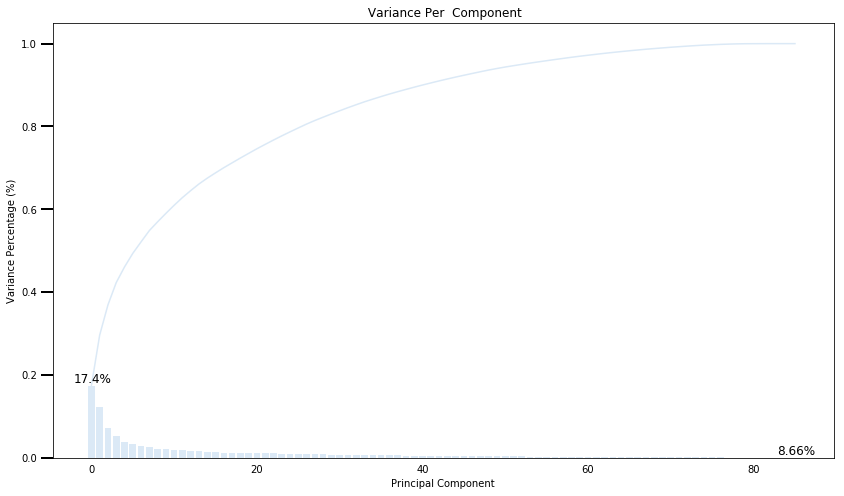

In [76]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    val = pca.explained_variance_ratio_
    num_of_component = len (val)
    ind = np.arange(num_of_component)  
    plt.figure(figsize=(14 ,8))
    ax = plt.subplot(111)
    ax.annotate(r"%s%%" % ((str(val[0]*100)[:4])), (ind[0]+0.2, val[0]), va="bottom", ha="center", fontsize=12)
    ax.annotate(r"%s%%" % ((str(val[-1]*100)[:4])), (ind[-1]+0.2, val[-1]), va="bottom", ha="center", fontsize=12)
    cumvals = np.cumsum(val)
    ax.bar(ind, val)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Percentage (%)")
    plt.title(' Variance Per  Component')
    
scree_plot(pca)   

In [77]:
# Re-apply PCA to the data while selecting for number of components to retain.
def do_pca(n, data):
    pca = PCA(n)
    X_pca=pca.fit_transform(data)
    return pca, X_pca

In [78]:
do_pca(30,df_imputed)

(PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 array([[ 4.14805432, -3.6386351 , -2.75756441, ..., -0.72017093,
         -0.92514504,  0.45439447],
        [-0.20433709, -0.94546223, -3.76561964, ..., -0.24088735,
         -0.05069951,  0.16641595],
        [-0.34904846, -0.10510585,  3.15599837, ...,  0.68828735,
         -0.77226688, -1.14085969],
        ..., 
        [ 5.46801421,  1.51060046,  1.29301851, ..., -0.08466628,
         -0.23371278, -0.08585125],
        [ 5.55643232, -4.30354067,  2.76458251, ...,  0.72959474,
         -0.03250515, -0.21846757],
        [ 0.27546629,  2.78893905,  3.05490762, ..., -1.44433545,
         -0.48800328,  0.20233277]]))

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
azdias_pca = pca.fit_transform(df_imputed)

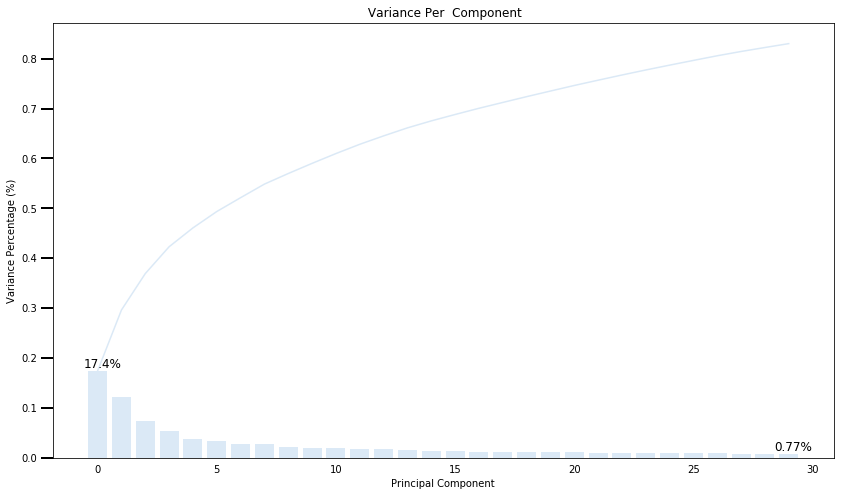

In [80]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

#### extract the most variance of dataset after applying PCA
#### drawing variance per principle comonent 
#### refit instant pca to assure the transformation 
##### retaining 30 principle component as it  around 80 % of the vairiance 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [81]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights(n,pca,df):
    name_list=list(df.columns)
    weights_list=list(pca.components_[n])
    df =pd.DataFrame(list(zip(name_list, weights_list)))
    df.set_axis(['Feature', 'Weights'], axis=1, inplace=True)
    df = df.sort_values(by=['Weights'] , ascending=False)
    df.set_index('Feature', inplace=True)
    return df

In [82]:
for i in range (3):
    print('\n Top 3- components {}\n'.format(i))
    print(weights(i,pca,df_1).tail(5))
    print('-----------------------------------------------')


 Top 3- components 0

                   Weights
Feature                   
KBA13_ANZAHL_PKW -0.192810
CAMEO_INTL_2015  -0.198454
LP_STATUS_GROB   -0.204203
LP_STATUS_FEIN   -0.206677
KKK              -0.212591
-----------------------------------------------

 Top 3- components 1

                        Weights
Feature                        
SEMIO_REL             -0.222038
FINANZ_SPARER         -0.234101
RELAT_AB              -0.255270
DECADE                -0.255270
PRAEGENDE_JUGENDJAHRE -0.255270
-----------------------------------------------

 Top 3- components 2

             Weights
Feature             
SEMIO_ERL  -0.203062
SEMIO_KRIT -0.278885
SEMIO_DOM  -0.313511
SEMIO_KAEM -0.343828
ANREDE_KZ  -0.371312
-----------------------------------------------


In [83]:
for i in range(3):
    print('\n Top 3+ components {}\n'.format(i))
    print(weights(i,pca,df_1).head(5))
    print('-----------------------------------------------')


 Top 3+ components 0

                  Weights
Feature                  
CAMEO_DEUG_2015  0.192136
PLZ8_ANTG2       0.191733
MOVEMENT         0.189757
CAMEO_DEU_2015   0.186615
PLZ8_ANTG3       0.186137
-----------------------------------------------

 Top 3+ components 1

                       Weights
Feature                       
ALTERSKATEGORIE_GROB  0.248386
FINANZ_VORSORGER      0.230813
SEMIO_ERL             0.196352
SEMIO_LUST            0.173735
RETOURTYP_BK_S        0.164255
-----------------------------------------------

 Top 3+ components 2

                    Weights
Feature                    
SEMIO_VERT         0.343464
SEMIO_SOZ          0.270489
SEMIO_FAM          0.269855
SEMIO_KULT         0.259609
FINANZ_MINIMALIST  0.144171
-----------------------------------------------


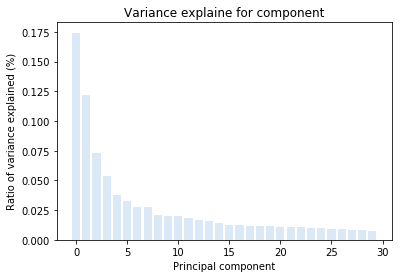

In [84]:

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.ylabel("Ratio of variance explained (%)")
plt.title("Variance explaine for component")
plt.xlabel("Principal component")

plt.show()

In [85]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display (df_imputed.tail())


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
695164,-1.763874,0.956776,0.321721,-1.470245,1.530106,-1.04496,0.111720,0.288193,0.582625,-1.355499,...,2.056168,1.429025,-1.223401,-0.190563,0.717951,-0.072734,1.182047,1.182047,-0.887748,0.088934
695165,-0.781357,0.956776,1.627772,-1.470245,1.530106,-1.04496,0.790461,1.729779,0.582625,-1.355499,...,0.018968,0.395518,0.573301,-1.197435,-0.152779,-0.809946,0.247483,0.247483,-0.205860,-1.247674
695166,-0.781357,-1.045177,0.321721,-0.016426,0.188848,-0.31928,-0.567021,-0.432600,-0.142731,1.024050,...,1.377101,1.429025,-0.325050,0.816310,0.282586,1.401690,0.247483,0.247483,1.157918,-1.247674
695167,-1.763874,-1.045177,-0.331304,-1.470245,1.530106,-0.31928,1.469203,1.729779,1.307980,-1.355499,...,2.056168,-2.705002,-2.121753,0.816310,0.717951,1.401690,1.182047,1.182047,1.157918,-1.247674
695168,1.183678,-1.045177,-1.637354,0.710483,-0.481782,1.13208,-0.567021,-1.153393,1.307980,1.024050,...,-0.660098,0.395518,0.573301,-0.190563,-0.588144,1.401690,-1.388004,-1.388004,0.476029,0.088934


### Discussion 2.3: Interpret Principal Components
 ##### from data dictionary we can interpret to know the prinicple component affect on analysis  and weight by negative or postive 
#### for component 0  people with lower  interest  
##### postive 
Feature                  
CAMEO_DEUG_2015  0.192136
PLZ8_ANTG2       0.191733
MOVEMENT         0.189757
CAMEO_DEU_2015   0.186615
PLZ8_ANTG3       0.186137

##### negative 

                   Weights
Feature                   
KBA13_ANZAHL_PKW -0.192810
CAMEO_INTL_2015  -0.198454
LP_STATUS_GROB   -0.204203
LP_STATUS_FEIN   -0.206677
KKK              -0.2125

===============================================================================
#### for compeonet 1 people with age more than 60 

##### psotive 
Feature                       
ALTERSKATEGORIE_GROB  0.248386
FINANZ_VORSORGER      0.230813
SEMIO_ERL             0.196352
SEMIO_LUST            0.173735
RETOURTYP_BK_S        0.164255


##### negative 
Top 3- components 1

                        Weights
Feature                        
SEMIO_REL             -0.222038
FINANZ_SPARER         -0.234101
RELAT_AB              -0.255270
DECADE                -0.255270
PRAEGENDE_JUGENDJAHRE -0.255270

======================================================================================
### for component 2  male tend to be actual and not dreamy 
#### postive  
                     Weights
Feature                    
SEMIO_VERT         0.343464
SEMIO_SOZ          0.270489
SEMIO_FAM          0.269855
SEMIO_KULT         0.259609
FINANZ_MINIMALIST  0.144171

------------------------------
 
#### negative 
  Top 3- components 2

             Weights
Feature             
SEMIO_ERL  -0.203062
SEMIO_KRIT -0.278884
SEMIO_DOM  -0.313511
SEMIO_KAEM -0.343827
ANREDE_KZ  -0.371312

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [86]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
    
    # compute the average within-cluster distances.
def get_kmeans_score(data ,center):
    kmeans = KMeans(n_clusters=center, random_state=0)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score 

In [87]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,12))
for center in centers : 
    scores.append(get_kmeans_score(azdias_pca,center))
display(scores)

[49625217.051408485,
 41678912.854980513,
 38129189.775183573,
 35975149.080857128,
 34717158.685776211,
 33575316.114829339,
 32391709.048101787,
 31331337.727289449,
 30439994.550100479,
 29842868.46610425,
 29359220.304267161]

In [88]:
display (centers)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Text(0.5,1,' score VS n_cluster')

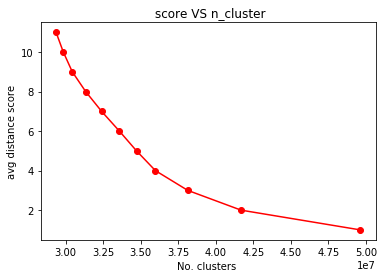

In [89]:
plt.plot(scores,centers,  linestyle='-', marker='o', color='r')
plt.xlabel('No. clusters ')
plt.ylabel('avg distance score')
plt.title(' score VS n_cluster')

In [90]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10, random_state=0)
model = kmeans.fit(azdias_pca)
Score = np.abs(model.score(azdias_pca))
cluster =  model.predict(azdias_pca)

In [91]:
display(pd.DataFrame(cluster).head())

,0
0,4
1,7
2,0
3,6
4,7


### Discussion 3.1: Apply Clustering to General Population



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [92]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [93]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_df = clean_data(customer)


number of than 20 is 94493
mulit feature ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:102: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,...,1.0,5.0,4.0,3.0,5.0,4.0,14,14,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,4.0,4.0,3.0,5.0,2.0,15,15,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,1.0,3.0,4.0,2.0,3.0,3.0,8,8,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,3.0,3.0,4.0,6.0,5.0,8,8,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,5.0,5.0,2.0,3.0,3.0,3,3,5.0,4.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,1.0,5.0,5.0,4.0,6.0,3.0,10,10,2.0,2.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,1.0,4.0,4.0,2.0,5.0,2.0,8,8,1.0,4.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,1.0,3.0,3.0,2.0,4.0,3.0,11,11,1.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,1.0,3.0,3.0,2.0,3.0,1.0,15,15,1.0,5.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,3.0,3.0,4.0,6.0,5.0,3,3,5.0,1.0


In [94]:
customer_df = customer_df.convert_objects(convert_numeric=True)
customer_df.info()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 796728 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     793930 non-null float64
ANREDE_KZ                796728 non-null int64
CJT_GESAMTTYP            792087 non-null float64
FINANZ_MINIMALIST        796728 non-null int64
FINANZ_SPARER            796728 non-null int64
FINANZ_VORSORGER         796728 non-null int64
FINANZ_ANLEGER           796728 non-null int64
FINANZ_UNAUFFAELLIGER    796728 non-null int64
FINANZ_HAUSBAUER         796728 non-null int64
FINANZTYP                796728 non-null int64
GEBURTSJAHR              796728 non-null int64
GFK_URLAUBERTYP          792087 non-null float64
GREEN_AVANTGARDE         796728 non-null int64
HEALTH_TYP               796728 non-null int64
LP_LEBENSPHASE_FEIN      792087 non-null float64
LP_LEBENSPHASE_GROB      792087 non-null float64
LP_FAMILIE_FEIN          792087 non-null float64
LP_FAMILIE_GROB          792087 non-null float64
LP_STATUS_FEIN           7920

In [95]:
n = customer_df['CAMEO_DEU_2015'].unique()
n

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [96]:
customer_df.replace (to_replace = n, value = np.NaN, regex = True, inplace = True)

In [97]:
customer_df = customer_df.convert_objects(convert_numeric=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [98]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796728 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     793930 non-null float64
ANREDE_KZ                796728 non-null int64
CJT_GESAMTTYP            792087 non-null float64
FINANZ_MINIMALIST        796728 non-null int64
FINANZ_SPARER            796728 non-null int64
FINANZ_VORSORGER         796728 non-null int64
FINANZ_ANLEGER           796728 non-null int64
FINANZ_UNAUFFAELLIGER    796728 non-null int64
FINANZ_HAUSBAUER         796728 non-null int64
FINANZTYP                796728 non-null int64
GEBURTSJAHR              796728 non-null int64
GFK_URLAUBERTYP          792087 non-null float64
GREEN_AVANTGARDE         796728 non-null int64
HEALTH_TYP               796728 non-null int64
LP_LEBENSPHASE_FEIN      792087 non-null float64
LP_LEBENSPHASE_GROB      792087 non-null float64
LP_FAMILIE_FEIN          792087 non-null float64
LP_FAMILIE_GROB          792087 non-null float64
LP_STATUS_FEIN           7920

In [151]:
customer_df_new=customer_df.dropna(axis=1)

In [152]:
customer_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796728 entries, 1 to 891220
Data columns (total 44 columns):
ANREDE_KZ                796728 non-null int64
FINANZ_MINIMALIST        796728 non-null int64
FINANZ_SPARER            796728 non-null int64
FINANZ_VORSORGER         796728 non-null int64
FINANZ_ANLEGER           796728 non-null int64
FINANZ_UNAUFFAELLIGER    796728 non-null int64
FINANZ_HAUSBAUER         796728 non-null int64
FINANZTYP                796728 non-null int64
GEBURTSJAHR              796728 non-null int64
GREEN_AVANTGARDE         796728 non-null int64
HEALTH_TYP               796728 non-null int64
NATIONALITAET_KZ         796728 non-null int64
PRAEGENDE_JUGENDJAHRE    796728 non-null int64
SEMIO_SOZ                796728 non-null int64
SEMIO_FAM                796728 non-null int64
SEMIO_REL                796728 non-null int64
SEMIO_MAT                796728 non-null int64
SEMIO_VERT               796728 non-null int64
SEMIO_LUST               796728 non-null in

##### do the same processs for azdias to  make sure that data is ready for our analysis 

In [153]:
#imputer
scaler = StandardScaler()
customer_df_new= pd.DataFrame(scaler.fit_transform(customer_df_new), columns = customer_df_new.columns)

In [154]:
customer_pca = pca.transform(customer_df_new)

In [155]:
customer_cluster =  model.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Clusters')

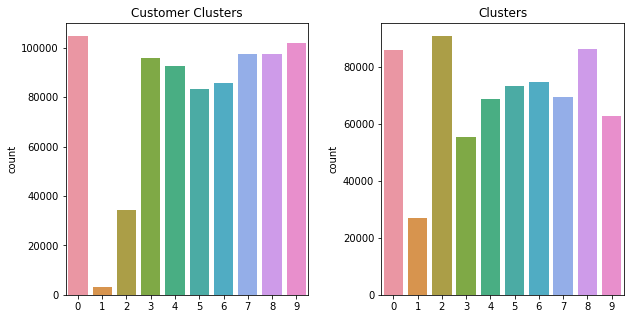

In [137]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customer_cluster, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(cluster, ax=axs[1])
axs[1].set_title('Clusters')


In [138]:
customer_clust_1 = pd.DataFrame(data=customer_cluster, columns=['Cluster'])
customer_clust_2 = pd.DataFrame(data=cluster, columns=['Cluster'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86db633438>]], dtype=object)

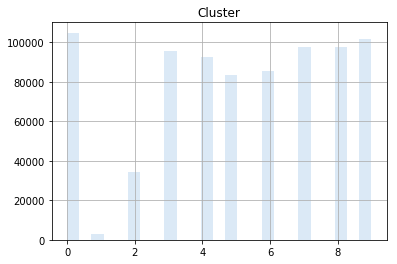

In [139]:
customer_clust_1.hist(bins=25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86dac53e10>]], dtype=object)

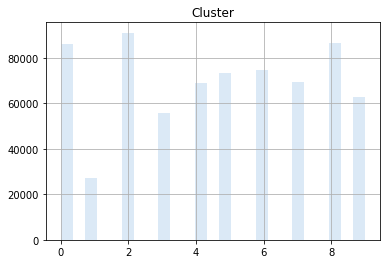

In [140]:
customer_clust_2.hist(bins=25)

In [141]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
def get_relative_cluster(data, k):
    for cc in range(0,k):
        s = data[data['Cluster']==cc]
        percent = len(s)/len(data)*100
        print ("precentage of size cluster {0} in %: {1:.2f}%".format(cc, percent))
        
get_relative_cluster(customer_clust_1,6)


precentage of size cluster 0 in %: 13.16%
precentage of size cluster 1 in %: 0.38%
precentage of size cluster 2 in %: 4.30%
precentage of size cluster 3 in %: 12.02%
precentage of size cluster 4 in %: 11.64%
precentage of size cluster 5 in %: 10.47%


In [142]:
get_relative_cluster ( customer_clust_2 ,6 )

precentage of size cluster 0 in %: 12.38%
precentage of size cluster 1 in %: 3.89%
precentage of size cluster 2 in %: 13.09%
precentage of size cluster 3 in %: 7.98%
precentage of size cluster 4 in %: 9.91%
precentage of size cluster 5 in %: 10.55%


##### it show the differances between two basic and predicted customer clustred  data set 

In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


In [144]:
clusters_cust = kmeans.predict(customer_pca)
clusters_pop = kmeans.fit_predict(azdias_pca)

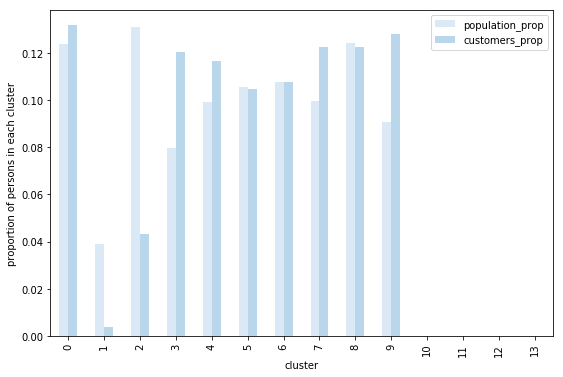

In [145]:
population_prop = []
customers_prop = []
x = [i for i in range(14)]
for i in range(14):
    population_prop.append((clusters_pop == i).sum()/len(clusters_pop))
    customers_prop.append((clusters_cust == i).sum()/len(clusters_cust))


df_general = pd.DataFrame({'cluster' : x, 'population_prop' : population_prop, 'customers_prop':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['population_prop', 'customers_prop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [146]:
#another monthod to detect centriod and postive and negtive cenriod 
#def kmeans_weights_feats(kmeans, df, clust_no):
    #weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=df.keys())
    #centroid = weights.iloc[clust_no, :]
    #cent_positive = centroid[centroid > 0].sort_values(ascending=False)
    #cent_negative = centroid[centroid < 0].sort_values(ascending=True)
    #return cent_positive, cent_negative

In [147]:
#obtain customer centriod # Obtaining cluster centroids and related PC strengths
#kmeans_weights_feats(kmeans, cluster , 2)

#### applaying nverse transformion 

In [148]:
centroid_0 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[0]))
centroid_0

array([-0.7659411 ,  0.36612875, -0.90925517,  0.97954595, -1.0465032 ,
       -0.97208763,  0.56552135,  0.62478008, -0.90358343, -0.52398678,
       -0.75761128, -0.41046365, -1.54150892,  0.31346433,  0.42928195,
        0.0056763 ,  0.34279247,  0.64100681,  0.78918767, -0.0398191 ,
        0.26535497, -0.72211016, -0.51338113, -0.71546808, -0.67941539,
       -0.43320779, -0.63622576, -0.40793952, -0.07335465,  0.16430276,
       -0.53322457,  0.09479786, -0.93423645, -0.61364703, -0.0952496 ,
        0.64081752,  0.42086106,  0.23080305,  0.37387015, -0.2202056 ,
        0.13142452, -0.2768312 , -1.54150892, -1.54150892])

In [149]:
centroid_6 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[6]))


In [150]:
overrepresented_6 = pd.Series(data = centroid_6, index = customer_df_new.columns)
overreresented_6

NameError: name 'overreresented_6' is not defined

In [ ]:
centroid_2 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))


In [ ]:

underpresented_2 = pd.Series(data = centroid_2, index = customer_df_new.columns)
underpresented_2

##### applaying different cluster for different cluster and see in inverse is over represented and who under reprsented 
by detecing centriod and then making psotive colleration and neagtive one of each cluster 

Cluster 6 is overrepresented in the customers data.
cluser 2 is underpresented 

### Discussion 3.3: Compare Customer Data to Demographics Data


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.